
Available Teams:
ARI, ATL, BAL, BUF, CAR, CHI, CIN, CLE, DAL, DEN, DET, GB, HOU, IND, JAX, KC, LA, LAC, LV, MIA, MIN, NE, NO, NYG, NYJ, PHI, PIT, SEA, SF, TB, TEN, WAS



Enter Team 1 abbreviation:  CLE
Enter Team 2 abbreviation:  DAL


Simulating CLE vs DAL...

📽 Saving animation to game_animation.mp4...
✅ Animation saved!

🏁 Final Score:
CLE: 14
DAL: 7


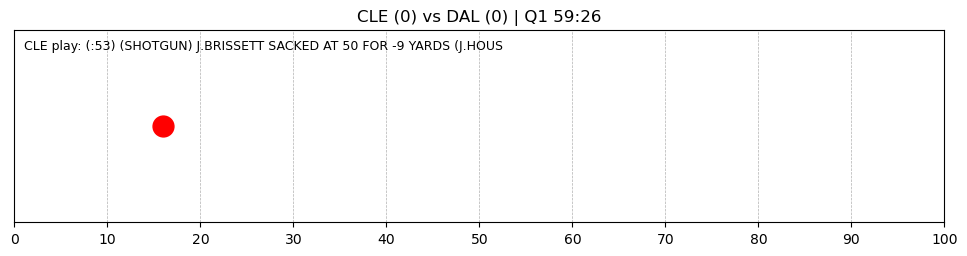

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random

# === Load Data ===
games_df = pd.read_csv("games.csv")
plays_df = pd.read_csv("plays.csv")

# === Animation ===
import os

class FieldAnimator:
    def __init__(self, team1, team2):
        self.team1 = team1
        self.team2 = team2
        self.fig, self.ax = plt.subplots(figsize=(12, 2.5))
        self.plays = []

    def log_play(self, yardline, possession, clock, quarter, desc, score):
        self.plays.append((yardline, possession, clock, quarter, desc[:60], score.copy()))

    def animate(self, save_path="game_animation.mp4"):
        def update(frame):
            self.ax.clear()
            yardline, possession, clock, quarter, desc, score = self.plays[frame]

            # Draw field
            self.ax.set_xlim(0, 100)
            self.ax.set_ylim(0, 1)
            self.ax.set_yticks([])
            self.ax.set_xticks(np.arange(0, 101, 10))
            self.ax.grid(True, axis='x', linestyle='--', linewidth=0.5)
            self.ax.set_title(f"{self.team1} ({score[self.team1]}) vs {self.team2} ({score[self.team2]}) | Q{int(quarter)} {clock}", fontsize=12)

            # Add player dot
            color = "red" if possession == self.team1 else "blue"
            self.ax.plot(yardline, 0.5, 'o', color=color, markersize=15)
            self.ax.text(1, 0.9, f"{possession} play: {desc}", fontsize=9, ha='left')

        # Save animation
        self.ani = animation.FuncAnimation(self.fig, update, frames=len(self.plays), repeat=False, interval=1000)
        print(f"📽 Saving animation to {save_path}...")
        ext = os.path.splitext(save_path)[1].lower()
        if ext == ".gif":
            self.ani.save(save_path, writer='pillow', fps=1)
        else:
            self.ani.save(save_path, writer='ffmpeg', fps=1)

        print("✅ Animation saved!")


# === Utility Functions ===
def format_clock(seconds_left):
    minutes = seconds_left // 60
    seconds = seconds_left % 60
    return f"{int(minutes):02}:{int(seconds):02}"


# === Game Simulation ===
def simulate_game(team1, team2):
    print(f"Simulating {team1} vs {team2}...\n")

    # Filter plays by offense/defense involvement
    offense_plays_team1 = plays_df[plays_df['possessionTeam'] == team1]
    offense_plays_team2 = plays_df[plays_df['possessionTeam'] == team2]

    teams = [team1, team2]
    score = {team1: 0, team2: 0}
    field_position = 25  # start on own 25
    possession = random.choice(teams)
    defense = team2 if possession == team1 else team1

    down = 1
    yards_to_go = 10
    seconds_left = 60 * 60  # 60 minutes
    quarter = 1

    animator = FieldAnimator(team1, team2)

    while seconds_left > 0:
        # Pick a random play from current possession team
        if possession == team1:
            play = offense_plays_team1.sample(1).iloc[0]
        else:
            play = offense_plays_team2.sample(1).iloc[0]

        play_desc = str(play['playDescription']).upper()
        yards = play['yardsGained'] if not np.isnan(play['yardsGained']) else 0
        play_time = np.random.randint(20, 46)
        seconds_left -= play_time
        if seconds_left <= 0:
            break
        quarter = 4 - (seconds_left // 900)

        # Update field position
        field_position += int(yards)
        field_position = max(0, min(99, field_position))

        # Score logic
        scored = False
        if "TOUCHDOWN" in play_desc:
            score[possession] += 7
            scored = True
        elif "FIELD GOAL IS GOOD" in play_desc:
            score[possession] += 3
            scored = True
        elif "SAFETY" in play_desc:
            score[defense] += 2
            scored = True

        # Log play
        animator.log_play(field_position, possession, format_clock(seconds_left), quarter, play_desc, score)

        if scored:
            # Reset field
            field_position = 25
            down = 1
            yards_to_go = 10
            possession, defense = defense, possession
            continue

        # Turnover logic
        turnover = any(x in play_desc for x in ["INTERCEPT", "FUMBLE", "TURNOVER", "PUNT", "MUFF"])
        if turnover:
            possession, defense = defense, possession
            field_position = 100 - field_position
            down = 1
            yards_to_go = 10
            continue

        # Down logic
        if yards >= yards_to_go:
            down = 1
            yards_to_go = 10
        else:
            down += 1
            yards_to_go -= int(yards)
            if down > 4:
                possession, defense = defense, possession
                field_position = 100 - field_position
                down = 1
                yards_to_go = 10

    # Animate and print final result
    animator.animate()
    print(f"\n🏁 Final Score:\n{team1}: {score[team1]}\n{team2}: {score[team2]}")


# === Prompt and Run ===
def main():
    all_teams = sorted(set(games_df['homeTeamAbbr']).union(games_df['visitorTeamAbbr']))
    print("\nAvailable Teams:\n" + ", ".join(all_teams))

    team1 = input("\nEnter Team 1 abbreviation: ").strip().upper()
    team2 = input("Enter Team 2 abbreviation: ").strip().upper()

    if team1 not in all_teams or team2 not in all_teams or team1 == team2:
        print("Invalid teams selected.")
        return

    simulate_game(team1, team2)

main()

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import time
import os

# Global variables for simulation settings
QUARTERS = 4
QUARTER_LENGTH = 15 * 60  # 15 minutes in seconds
COMPUTE_INTENSITY = 50  # Controls how much computation is done per play

class NFLSimulator:
    def __init__(self, games_file="games.csv", plays_file="plays.csv"):
        """Initialize the NFL simulator with game and play data"""
        print("Loading data files...")
        self.games_df = pd.read_csv(games_file)
        self.plays_df = pd.read_csv(plays_file)
        
        # Get available teams
        self.teams = np.unique(np.concatenate([
            self.games_df['homeTeamAbbr'].unique(), 
            self.games_df['visitorTeamAbbr'].unique()
        ]))
        
        # Preprocess play data for faster simulation
        self._preprocess_data()
        
        print(f"Simulator ready with {len(self.teams)} teams available.")
    
    def _preprocess_data(self):
        """Preprocess play data for simulation"""
        # Create play type categories
        self.plays_df['playType'] = 'Other'
        
        # Categorize pass plays
        if 'isDropback' in self.plays_df.columns:
            pass_mask = (self.plays_df['isDropback'] == 1) & (~self.plays_df['passResult'].isna())
            self.plays_df.loc[pass_mask, 'playType'] = 'Pass'
        
        # Categorize run plays
        if 'isDropback' in self.plays_df.columns:
            run_mask = (self.plays_df['isDropback'] != 1) & (~self.plays_df['yardsGained'].isna())
            self.plays_df.loc[run_mask, 'playType'] = 'Run'
        
        # Categorize special teams plays
        if 'playDescription' in self.plays_df.columns:
            punt_mask = self.plays_df['playDescription'].str.contains('PUNT', na=False)
            fg_mask = self.plays_df['playDescription'].str.contains('FIELD GOAL', na=False)
            
            self.plays_df.loc[punt_mask, 'playType'] = 'Punt'
            self.plays_df.loc[fg_mask, 'playType'] = 'Field Goal'
        
        # Create play outcome dictionaries
        self.team_plays = {}
        for team in self.teams:
            team_df = self.plays_df[self.plays_df['possessionTeam'] == team]
            if len(team_df) > 0:
                self.team_plays[team] = {
                    'Pass': team_df[team_df['playType'] == 'Pass'],
                    'Run': team_df[team_df['playType'] == 'Run'],
                    'Punt': team_df[team_df['playType'] == 'Punt'],
                    'Field Goal': team_df[team_df['playType'] == 'Field Goal']
                }
    
    def display_available_teams(self):
        """Display all available teams for simulation"""
        teams = sorted(self.teams)
        print("\nAvailable Teams:")
        print(", ".join(teams))
        return teams
    
    def _intensive_computation(self, iterations=100):
        """Run intensive computation to make simulation take longer"""
        # Create large matrices
        a = np.random.normal(0, 1, (200, 200))
        b = np.random.normal(0, 1, (200, 200))
        
        # Run computationally intensive operations
        for _ in range(iterations):
            # Matrix multiplication
            c = np.matmul(a, b)
            
            # Matrix operations
            d = np.linalg.norm(c, axis=1)
            e = np.sort(d)
            
            # More operations
            f = np.exp(c[:10, :10])
            g = np.sin(c[10:20, 10:20])
            
            # Update matrices slightly
            a = 0.99 * a + 0.01 * np.random.normal(0, 1, (200, 200))
            b = 0.99 * b + 0.01 * np.random.normal(0, 1, (200, 200))
    
    def get_play(self, team, play_type, field_position, down, distance):
        """Get a play outcome based on historical data"""
        # Run computation to make this function take longer
        self._intensive_computation(COMPUTE_INTENSITY)
        
        # If no data available for this team/play type, return default
        if team not in self.team_plays or play_type not in self.team_plays[team]:
            return {
                'yards': np.random.normal(5, 10),
                'time': np.random.randint(25, 40),
                'turnover': np.random.random() < 0.05,
                'touchdown': np.random.random() < 0.05,
                'field_goal': play_type == 'Field Goal' and np.random.random() < 0.7,
                'description': f"{play_type} play (simulated)"
            }
        
        # Get play data for this team/play type
        plays = self.team_plays[team][play_type]
        
        if len(plays) == 0:
            # No plays of this type, return default
            return {
                'yards': np.random.normal(5, 10),
                'time': np.random.randint(25, 40),
                'turnover': np.random.random() < 0.05,
                'touchdown': np.random.random() < 0.05,
                'field_goal': play_type == 'Field Goal' and np.random.random() < 0.7,
                'description': f"{play_type} play (no data)"
            }
        
        # Select a random play
        play = plays.sample(1).iloc[0]
        
        # Get yards gained (default to 0 if not available)
        yards = play['yardsGained'] if 'yardsGained' in play and not pd.isna(play['yardsGained']) else 0
        
        # Add some randomness to yards gained
        yards = yards + np.random.normal(0, yards/4 if yards > 0 else 2)
        
        # Check for touchdown based on field position
        touchdown = False
        if field_position + yards >= 100:
            touchdown = True
            yards = 100 - field_position
        
        # Check for turnover
        turnover = False
        if 'playDescription' in play:
            desc = str(play['playDescription']).upper()
            turnover = 'INTERCEPTION' in desc or 'FUMBLE' in desc
        
        # Check for field goal
        field_goal = False
        if play_type == 'Field Goal' and 'playDescription' in play:
            desc = str(play['playDescription']).upper()
            field_goal = 'FIELD GOAL IS GOOD' in desc
            
            # Adjust field goal probability based on field position
            if field_position >= 65:  # 35 yard line or closer
                field_goal = np.random.random() < 0.9  # 90% probability
            elif field_position >= 55:  # 45 yard line or closer
                field_goal = np.random.random() < 0.7  # 70% probability
            else:
                field_goal = np.random.random() < 0.4  # 40% probability
        
        # Create a play description
        if touchdown:
            description = f"{play_type} play for TOUCHDOWN!"
        elif field_goal:
            description = "FIELD GOAL IS GOOD"
        elif turnover:
            if play_type == 'Pass':
                description = "Pass INTERCEPTED"
            else:
                description = f"{play_type} play - FUMBLE"
        else:
            description = f"{play_type} play for {yards:.1f} yards"
        
        # Estimate play time
        play_time = np.random.randint(25, 40)
        
        return {
            'yards': yards,
            'time': play_time,
            'turnover': turnover,
            'touchdown': touchdown,
            'field_goal': field_goal,
            'description': description
        }
    
    def choose_play_type(self, down, distance, field_position, score_diff, time_remaining):
        """Choose play type based on game situation"""
        # Base probabilities
        pass_prob = 0.6
        run_prob = 0.4
        fg_prob = 0.0
        punt_prob = 0.0
        
        # Adjust based on down
        if down == 3:
            # More likely to pass on 3rd down
            pass_prob += 0.2
            run_prob -= 0.2
        elif down == 4:
            # 4th down decision making
            if field_position > 65:  # Inside opponent's 35
                # Field goal territory
                fg_prob = 0.8
                pass_prob = 0.1
                run_prob = 0.1
                punt_prob = 0.0
            elif field_position > 50:  # Between 50 and opponent's 35
                # Go for it or punt
                if distance <= 2:  # Short yardage
                    pass_prob = 0.3
                    run_prob = 0.4
                    punt_prob = 0.3
                else:
                    punt_prob = 0.9
                    pass_prob = 0.05
                    run_prob = 0.05
            else:  # Own territory
                # Likely punt
                punt_prob = 0.95
                pass_prob = 0.025
                run_prob = 0.025
        
        # Adjust for time remaining
        if time_remaining < 120:  # Last 2 minutes
            if score_diff < 0:  # Losing
                pass_prob += 0.2  # More passes when behind late
                run_prob -= 0.2
            elif score_diff > 14:  # Winning big
                run_prob += 0.2  # More runs when ahead late
                pass_prob -= 0.2
        
        # Normalize probabilities
        total = pass_prob + run_prob + fg_prob + punt_prob
        pass_prob /= total
        run_prob /= total
        fg_prob /= total
        punt_prob /= total
        
        # Choose play type
        r = np.random.random()
        if r < pass_prob:
            return 'Pass'
        elif r < pass_prob + run_prob:
            return 'Run'
        elif r < pass_prob + run_prob + fg_prob:
            return 'Field Goal'
        else:
            return 'Punt'
    
    def simulate_game(self, team1, team2):
        """Simulate a full game between two teams"""
        start_time = time.time()
        print(f"\nSimulating {team1} vs {team2}...")
        
        # Game state initialization
        score = {team1: 0, team2: 0}
        possession = np.random.choice([team1, team2])  # Random team starts with ball
        field_position = 25  # Start at own 25 yard line
        down = 1
        distance = 10
        time_remaining = QUARTERS * QUARTER_LENGTH
        quarter = 1
        
        # Game statistics
        stats = {
            team1: {'total_yards': 0, 'pass_yards': 0, 'rush_yards': 0, 'turnovers': 0},
            team2: {'total_yards': 0, 'pass_yards': 0, 'rush_yards': 0, 'turnovers': 0}
        }
        
        # Drive tracking
        drive_summary = []
        current_drive = {
            'team': possession,
            'start_position': field_position,
            'plays': [],
            'result': None,
            'quarter': quarter,
            'time': f"{time_remaining // 60:02d}:{time_remaining % 60:02d}"
        }
        
        # Team colors
        team_colors = {team1: 'red', team2: 'blue'}
        
        # Game loop
        while time_remaining > 0:
            # Get the defensive team
            defense = team2 if possession == team1 else team1
            
            # Calculate score differential from possession team perspective
            score_diff = score[possession] - score[defense]
            
            # Choose play type
            play_type = self.choose_play_type(
                down, distance, field_position, score_diff, time_remaining
            )
            
            # Get play result
            play = self.get_play(possession, play_type, field_position, down, distance)
            
            # Apply play result
            yards_gained = play['yards']
            play_time = play['time']
            
            # Update statistics
            stats[possession]['total_yards'] += yards_gained
            if play_type == 'Pass':
                stats[possession]['pass_yards'] += yards_gained
            elif play_type == 'Run':
                stats[possession]['rush_yards'] += yards_gained
            
            # Calculate time used
            time_remaining -= play_time
            
            # Update quarter if needed
            new_quarter = min(4, 1 + (QUARTERS * QUARTER_LENGTH - time_remaining) // QUARTER_LENGTH)
            quarter_change = new_quarter > quarter
            quarter = new_quarter
            
            # Format game clock
            minutes = time_remaining // 60
            seconds = time_remaining % 60
            clock_display = f"{int(minutes):02}:{int(seconds):02}"
            
            # Add play to current drive
            current_drive['plays'].append({
                'type': play_type,
                'yards': yards_gained,
                'description': play['description'],
                'down': down,
                'distance': distance,
                'field_position': field_position
            })
            
            # Handle scoring plays
            if play['touchdown']:
                score[possession] += 7  # TD + PAT for simplicity
                current_drive['result'] = 'TOUCHDOWN'
                
                # Complete the drive
                current_drive['end_position'] = 100
                current_drive['yards'] = current_drive['end_position'] - current_drive['start_position']
                drive_summary.append(current_drive)
                
                # Print drive summary
                print(f"\nDrive Summary - {possession} TOUCHDOWN!")
                print(f"Started at: {current_drive['start_position']} yard line")
                print(f"Plays: {len(current_drive['plays'])}")
                print(f"Yards: {current_drive['yards']}")
                print(f"Time: {current_drive['time']} in Q{current_drive['quarter']}")
                print(f"Score: {possession} {score[possession]}, {defense} {score[defense]}")
                
                # Start new drive
                possession = defense
                field_position = 25
                down = 1
                distance = 10
                current_drive = {
                    'team': possession,
                    'start_position': field_position,
                    'plays': [],
                    'result': None,
                    'quarter': quarter,
                    'time': clock_display
                }
                continue
                
            elif play['field_goal']:
                score[possession] += 3
                current_drive['result'] = 'FIELD GOAL'
                
                # Complete the drive
                current_drive['end_position'] = field_position
                current_drive['yards'] = current_drive['end_position'] - current_drive['start_position']
                drive_summary.append(current_drive)
                
                # Print drive summary
                print(f"\nDrive Summary - {possession} FIELD GOAL!")
                print(f"Started at: {current_drive['start_position']} yard line")
                print(f"Plays: {len(current_drive['plays'])}")
                print(f"Yards: {current_drive['yards']}")
                print(f"Time: {current_drive['time']} in Q{current_drive['quarter']}")
                print(f"Score: {possession} {score[possession]}, {defense} {score[defense]}")
                
                # Start new drive
                possession = defense
                field_position = 25
                down = 1
                distance = 10
                current_drive = {
                    'team': possession,
                    'start_position': field_position,
                    'plays': [],
                    'result': None,
                    'quarter': quarter,
                    'time': clock_display
                }
                continue
            
            # Handle turnovers
            if play['turnover']:
                stats[possession]['turnovers'] += 1
                current_drive['result'] = 'TURNOVER'
                
                # Complete the drive
                current_drive['end_position'] = field_position + yards_gained
                current_drive['yards'] = current_drive['end_position'] - current_drive['start_position']
                drive_summary.append(current_drive)
                
                # Print drive summary
                print(f"\nDrive Summary - {possession} TURNOVER!")
                print(f"Started at: {current_drive['start_position']} yard line")
                print(f"Plays: {len(current_drive['plays'])}")
                print(f"Yards: {current_drive['yards']}")
                print(f"Time: {current_drive['time']} in Q{current_drive['quarter']}")
                print(f"Final play: {play['description']}")
                
                # Switch possession
                possession = defense
                field_position = 100 - (field_position + yards_gained)  # Flip field
                field_position = max(0, min(100, field_position))  # Keep in bounds
                down = 1
                distance = 10
                
                # Start new drive
                current_drive = {
                    'team': possession,
                    'start_position': field_position,
                    'plays': [],
                    'result': None,
                    'quarter': quarter,
                    'time': clock_display
                }
                continue
            
            # Handle punts
            if play_type == 'Punt':
                # Punt distance based on field position
                punt_distance = np.random.normal(45, 8)
                current_drive['result'] = 'PUNT'
                
                # Complete the drive
                current_drive['end_position'] = field_position
                current_drive['yards'] = current_drive['end_position'] - current_drive['start_position']
                drive_summary.append(current_drive)
                
                # Print drive summary
                print(f"\nDrive Summary - {possession} PUNT!")
                print(f"Started at: {current_drive['start_position']} yard line")
                print(f"Plays: {len(current_drive['plays'])}")
                print(f"Yards: {current_drive['yards']}")
                print(f"Time: {current_drive['time']} in Q{current_drive['quarter']}")
                print(f"Punt distance: {punt_distance:.1f} yards")
                
                # Switch possession
                possession = defense
                field_position = max(0, min(100, 100 - (field_position + punt_distance)))
                down = 1
                distance = 10
                
                # Start new drive
                current_drive = {
                    'team': possession,
                    'start_position': field_position,
                    'plays': [],
                    'result': None,
                    'quarter': quarter,
                    'time': clock_display
                }
                continue
            
            # Update field position
            field_position += yards_gained
            
            # Check for first down
            if yards_gained >= distance:
                down = 1
                distance = 10
                if field_position > 100:
                    field_position = 100  # Cap at 100 (goal line)
            else:
                down += 1
                distance -= yards_gained
                if field_position > 100:
                    # Crossed goal line
                    score[possession] += 7  # TD + PAT
                    current_drive['result'] = 'TOUCHDOWN'
                    
                    # Complete the drive
                    current_drive['end_position'] = 100
                    current_drive['yards'] = current_drive['end_position'] - current_drive['start_position']
                    drive_summary.append(current_drive)
                    
                    # Print drive summary
                    print(f"\nDrive Summary - {possession} TOUCHDOWN!")
                    print(f"Started at: {current_drive['start_position']} yard line")
                    print(f"Plays: {len(current_drive['plays'])}")
                    print(f"Yards: {current_drive['yards']}")
                    print(f"Time: {current_drive['time']} in Q{current_drive['quarter']}")
                    print(f"Score: {possession} {score[possession]}, {defense} {score[defense]}")
                    
                    # Switch possession
                    possession = defense
                    field_position = 25
                    down = 1
                    distance = 10
                    
                    # Start new drive
                    current_drive = {
                        'team': possession,
                        'start_position': field_position,
                        'plays': [],
                        'result': None,
                        'quarter': quarter,
                        'time': clock_display
                    }
                    continue
                
                if down > 4:
                    # Turnover on downs
                    current_drive['result'] = 'TURNOVER ON DOWNS'
                    
                    # Complete the drive
                    current_drive['end_position'] = field_position
                    current_drive['yards'] = current_drive['end_position'] - current_drive['start_position']
                    drive_summary.append(current_drive)
                    
                    # Print drive summary
                    print(f"\nDrive Summary - {possession} TURNOVER ON DOWNS!")
                    print(f"Started at: {current_drive['start_position']} yard line")
                    print(f"Plays: {len(current_drive['plays'])}")
                    print(f"Yards: {current_drive['yards']}")
                    print(f"Time: {current_drive['time']} in Q{current_drive['quarter']}")
                    print(f"Failed to convert: {down-1} & {distance + yards_gained}")
                    
                    # Switch possession
                    possession = defense
                    field_position = 100 - field_position  # Flip field
                    down = 1
                    distance = 10
                    
                    # Start new drive
                    current_drive = {
                        'team': possession,
                        'start_position': field_position,
                        'plays': [],
                        'result': None,
                        'quarter': quarter,
                        'time': clock_display
                    }
                    continue
            
            # Keep field position in bounds
            field_position = max(0, min(100, field_position))
            
            # Handle end of quarter
            if quarter_change:
                print(f"\nEnd of Quarter {quarter-1}")
                print(f"Score: {team1} {score[team1]}, {team2} {score[team2]}")
                
                # If it's halftime, add a special message
                if quarter == 3:
                    print("HALFTIME")
                    
                    # Complete the current drive and start a new one after halftime
                    if current_drive['plays']:
                        current_drive['result'] = 'END OF HALF'
                        current_drive['end_position'] = field_position
                        current_drive['yards'] = current_drive['end_position'] - current_drive['start_position']
                        drive_summary.append(current_drive)
                        
                        # Start a new drive in the second half
                        current_drive = {
                            'team': possession,
                            'start_position': field_position,
                            'plays': [],
                            'result': None,
                            'quarter': quarter,
                            'time': clock_display
                        }
        
        # Game over
        elapsed = time.time() - start_time
        print(f"\nSimulation completed in {elapsed:.2f} seconds")
        
        # If there's an incomplete drive at the end of the game, record it
        if current_drive['plays']:
            current_drive['result'] = 'END OF GAME'
            current_drive['end_position'] = field_position
            current_drive['yards'] = current_drive['end_position'] - current_drive['start_position']
            drive_summary.append(current_drive)
        
        print(f"\n🏁 Final Score:")
        print(f"{team1}: {score[team1]}")
        print(f"{team2}: {score[team2]}")
        
        # Print summary statistics
        print("\n📊 Game Statistics:")
        print(f"{team1.ljust(4)} | {team2.ljust(4)}")
        print("-" * 30)
        print(f"Total Yards: {stats[team1]['total_yards']:.0f} | {stats[team2]['total_yards']:.0f}")
        print(f"Pass Yards: {stats[team1]['pass_yards']:.0f} | {stats[team2]['pass_yards']:.0f}")
        print(f"Rush Yards: {stats[team1]['rush_yards']:.0f} | {stats[team2]['rush_yards']:.0f}")
        print(f"Turnovers: {stats[team1]['turnovers']} | {stats[team2]['turnovers']}")
        
        # Print drive summary
        print("\n🏈 Drive Summary:")
        
        team1_drives = [d for d in drive_summary if d['team'] == team1]
        team2_drives = [d for d in drive_summary if d['team'] == team2]
        
        print(f"\n{team1} Drives: {len(team1_drives)}")
        td_drives = len([d for d in team1_drives if d['result'] == 'TOUCHDOWN'])
        fg_drives = len([d for d in team1_drives if d['result'] == 'FIELD GOAL'])
        punt_drives = len([d for d in team1_drives if d['result'] == 'PUNT'])
        turnover_drives = len([d for d in team1_drives if d['result'] in ['TURNOVER', 'TURNOVER ON DOWNS']])
        
        print(f"  Touchdowns: {td_drives}")
        print(f"  Field Goals: {fg_drives}")
        print(f"  Punts: {punt_drives}")
        print(f"  Turnovers: {turnover_drives}")
        
        print(f"\n{team2} Drives: {len(team2_drives)}")
        td_drives = len([d for d in team2_drives if d['result'] == 'TOUCHDOWN'])
        fg_drives = len([d for d in team2_drives if d['result'] == 'FIELD GOAL'])
        punt_drives = len([d for d in team2_drives if d['result'] == 'PUNT'])
        turnover_drives = len([d for d in team2_drives if d['result'] in ['TURNOVER', 'TURNOVER ON DOWNS']])
        
        print(f"  Touchdowns: {td_drives}")
        print(f"  Field Goals: {fg_drives}")
        print(f"  Punts: {punt_drives}")
        print(f"  Turnovers: {turnover_drives}")
        
        return {
            'team1': team1,
            'team2': team2,
            'score': score,
            'drive_summary': drive_summary,
            'stats': stats
        }
    
    def animate_game(self, team1, team2, play_history):
        """This method is removed since we're not using animation"""
        pass
        
# Main function
def main():
    # Initialize the simulator
    simulator = NFLSimulator()
    
    # Display available teams
    available_teams = simulator.display_available_teams()
    
    # Get team selections
    while True:
        try:
            team1 = input("\nEnter Team 1 abbreviation: ").strip().upper()
            if team1 not in available_teams:
                print(f"Team {team1} not found. Please select from available teams.")
                continue
                
            team2 = input("Enter Team 2 abbreviation: ").strip().upper()
            if team2 not in available_teams:
                print(f"Team {team2} not found. Please select from available teams.")
                continue
                
            if team1 == team2:
                print("Please select two different teams.")
                continue
                
            break
        except Exception as e:
            print(f"Error: {e}")
    
    # Simulate the game
    game_result = simulator.simulate_game(team1, team2)
    
    return game_result

if __name__ == "__main__":
    main()

Loading data files...
Simulator ready with 32 teams available.

Available Teams:
ARI, ATL, BAL, BUF, CAR, CHI, CIN, CLE, DAL, DEN, DET, GB, HOU, IND, JAX, KC, LA, LAC, LV, MIA, MIN, NE, NO, NYG, NYJ, PHI, PIT, SEA, SF, TB, TEN, WAS



Enter Team 1 abbreviation:  DEN
Enter Team 2 abbreviation:  DET



Simulating DEN vs DET...

Drive Summary - DET PUNT!
Started at: 25 yard line
Plays: 4
Yards: 3.756944642141324
Time: 60:00 in Q1
Punt distance: 58.7 yards

Drive Summary - DEN PUNT!
Started at: 12.533722621436482 yard line
Plays: 6
Yards: 49.48457784764438
Time: 57:54 in Q1
Punt distance: 54.5 yards

Drive Summary - DET TURNOVER ON DOWNS!
Started at: 0 yard line
Plays: 4
Yards: 7.879917224690845
Time: 54:41 in Q1
Failed to convert: 4 & 2.926186722932962

Drive Summary - DEN TOUCHDOWN!
Started at: 92.12008277530916 yard line
Plays: 1
Yards: 7.879917224690843
Time: 52:36 in Q1
Score: DEN 7, DET 0

Drive Summary - DET TOUCHDOWN!
Started at: 25 yard line
Plays: 6
Yards: 75
Time: 52:08 in Q1
Score: DET 7, DEN 7

Drive Summary - DEN PUNT!
Started at: 25 yard line
Plays: 9
Yards: 30.38846919971666
Time: 49:02 in Q1
Punt distance: 42.8 yards

Drive Summary - DET TURNOVER!
Started at: 1.8223310286657295 yard line
Plays: 2
Yards: 2.5364278482090903
Time: 44:32 in Q2
Final play: Run play - FUMBL